<a href="https://colab.research.google.com/github/sushanttwayana/ML-DL-Strategies-Toolkit/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning for Image Classification in PyTorch

How a CNN learns ([source](https://developer.nvidia.com/discover/convolutional-neural-network)):

![cnn-learning](https://developer.nvidia.com/sites/default/files/pictures/2018/convolutional_neural_network.png)

Layer visualization ([source](https://medium.com/analytics-vidhya/deep-learning-visualization-and-interpretation-of-neural-networks-2f3f82f501c5)):

![cnn-learning](https://miro.medium.com/max/1610/1*WysCJ6Ynecvviwctt6WDlQ.png)


**Transfer Learning**

The idea behind the transfer learning is that we take a CNN that has already been trained on the very large dataset called pretrained models(there is a large dataset which contains 1million categories across thousands categories and several companies have trained on this ImageNet dataset) and then we use some of the layers of this model to train custom models that we are working on. The features learned in lower layers low-level feature, mid-level, high-level features and they are going to be useful to solve any image classfication problem in general.The only thing that we might need to change may be classifier at the very end.

## Downloading the Dataset

We'll use the Oxford-IIIT Pets dataset from https://course.fast.ai/datasets . It is 37 category (breeds) pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting.

In [ ]:
from torchvision.datasets.utils import download_url

In [ ]:
download_url('https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz', '.')

100%|██████████| 811706944/811706944 [00:46<00:00, 17570282.18it/s]


In [ ]:
import tarfile

with tarfile.open('./oxford-iiit-pet.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
from torch.utils.data import Dataset

In [ ]:
import os

DATA_DIR = './data/oxford-iiit-pet/images'

files = os.listdir(DATA_DIR)
files[:5]

['great_pyrenees_91.jpg',
 'Maine_Coon_8.jpg',
 'newfoundland_130.jpg',
 'Abyssinian_49.jpg',
 'yorkshire_terrier_54.jpg']

The class is actually the part of filename


In [ ]:
def parse_breed(fname):
    parts = fname.split('_')
    return ' '.join(parts[:-1])

In [ ]:
parse_breed(files[4])

'yorkshire terrier'

In [ ]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

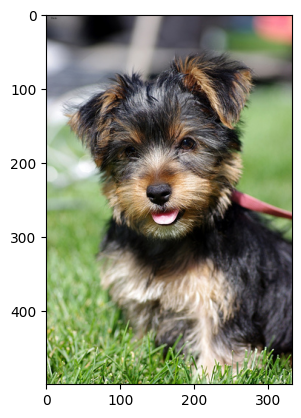

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(open_image(os.path.join(DATA_DIR, files[4])))

## Creating a Custom PyTorch Dataset

In [ ]:
import os
import torch
from torch.utils.data import Dataset

class PetsDataset(Dataset):
    def __init__(self, root, transform):
        super().__init__()
        self.root = root
        self.files = [fname for fname in os.listdir(root) if fname.endswith('.jpg')]
        self.classes = list(set(parse_breed(fname) for fname in files))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        fpath = os.path.join(self.root, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(parse_breed(fname))
        return img, class_idx

In [ ]:
import torchvision.transforms as T

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
dataset = PetsDataset(DATA_DIR, T.Compose([T.Resize(img_size),
                                           T.Pad(8, padding_mode='reflect'),
                                           T.RandomCrop(img_size),
                                           T.ToTensor(),
                                           T.Normalize(*imagenet_stats)]))

In [ ]:
len(dataset)

7390

In [ ]:
dataset.classes

['Sphynx',
 'saint bernard',
 'British Shorthair',
 'keeshond',
 'wheaten terrier',
 'Abyssinian',
 'basset hound',
 'pomeranian',
 'Persian',
 'havanese',
 'newfoundland',
 'english cocker spaniel',
 'Siamese',
 'great pyrenees',
 'samoyed',
 'Birman',
 'beagle',
 'american bulldog',
 'japanese chin',
 'yorkshire terrier',
 'chihuahua',
 'Bombay',
 'Bengal',
 'american pit bull terrier',
 'shiba inu',
 'miniature pinscher',
 'boxer',
 'german shorthaired',
 'Maine Coon',
 'Ragdoll',
 'scottish terrier',
 'pug',
 'english setter',
 'Egyptian Mau',
 'leonberger',
 'Russian Blue',
 'staffordshire bull terrier']

In [ ]:
len(dataset.classes)

37

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: newfoundland (10)


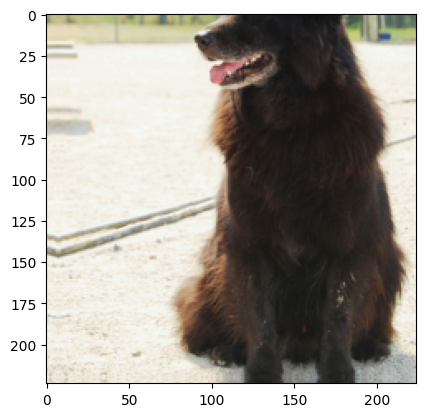

In [ ]:
show_image(*dataset[2])

## Creating Training and Validation Sets

In [ ]:
from torch.utils.data import random_split

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])

In [ ]:
from torch.utils.data import DataLoader
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
print(len(train_dl))
print(len(valid_dl))

26
2


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *imagenet_stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


In [ ]:
show_batch(train_dl)

## Modifying a Pretrained Model (ResNet34)

Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))


In [ ]:
from torchvision import models

class PetsModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model.resnets34()

AttributeError: 'PetsModel' object has no attribute 'resnets34'

In [ ]:
# Also loads the corresponding required weights
model.resnet34(pretrained=True)
resnets = model.resnet34(pretrained=True)

NameError: name 'model' is not defined

## GPU Utilities and Training Loop

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Finetuning the Pretrained Model

In [ ]:
model = PetsModel(len(dataset.classes),pretrained=True)
to_device(model, device);

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 54.3MB/s]


In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.874664306640625, 'val_acc': 0.03029494732618332}]

In [ ]:
epochs = 6
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00589, train_loss: 1.2896, val_loss: 39.9499, val_acc: 0.0824


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 2.1283, val_loss: 2.9395, val_acc: 0.2393


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 1.3715, val_loss: 2.9348, val_acc: 0.3276


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 0.8822, val_loss: 1.7124, val_acc: 0.5454


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 0.5413, val_loss: 0.8469, val_acc: 0.7529


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 0.3409, val_loss: 0.6533, val_acc: 0.7910
CPU times: user 29.7 s, sys: 20.4 s, total: 50.1 s
Wall time: 2min 22s


## Training a model from scratch

Let's repeat the training without using weights from the pretrained ResNet34 model.

In [ ]:
model2 = PetsModel(len(dataset.classes), pretrained=False)
to_device(model2, device);

In [ ]:
history2 = [evaluate(model2, valid_dl)]
history2

[{'val_loss': 77.91902923583984, 'val_acc': 0.030316457152366638}]

In [ ]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl,
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func)

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00589, train_loss: 3.5882, val_loss: 122.8458, val_acc: 0.0240


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00994, train_loss: 3.4328, val_loss: 4.3124, val_acc: 0.0692


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00812, train_loss: 3.1612, val_loss: 3.6285, val_acc: 0.0875


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00463, train_loss: 2.9008, val_loss: 3.1846, val_acc: 0.1484


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00133, train_loss: 2.6612, val_loss: 3.0503, val_acc: 0.1765


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00000, train_loss: 2.4516, val_loss: 2.6059, val_acc: 0.2459
CPU times: user 33.1 s, sys: 23.7 s, total: 56.8 s
Wall time: 2min 26s


While the pretrained model reached an accuracy of 80% in less than 3 minutes, the model without pretrained weights could only reach an accuracy of 24%.